In [248]:
#load in final data and plot the results
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [249]:
#load in data
data = pd.read_csv('data/final_merged_data.csv')

In [250]:
# Remove rows that have all NaNs
data = data.dropna(how='all')

# Remove empty rows
data = data.dropna(subset=['Zip Code'], how='all')

# Remove rows that have only year and zip code
data = data.dropna(subset=['Year', 'Zip Code'], how='all')

# Remove rows where all columns except 'Zip Code' and 'Year' are NaN
data = data.dropna(how='all', subset=[col for col in data.columns if col not in ['Zip Code', 'Year']])

# Remove rows where median income is NaN or very negative
data = data[data['Median income (dollars)'] > 0]

# Remove rows with 2023 data
data = data[data['Year'] != 2023]

# Remove rows that do not have median income values
data = data.dropna(subset=['Median income (dollars)'])

# Send this to csv for further analysis
data.to_csv('data/in_process_final.csv', index=False)

In [251]:
# oops need to convert HPI with base 2000 to float
data['HPI with 2000 base'] = pd.to_numeric(data['HPI with 2000 base'], errors='coerce')

In [252]:
print(data.columns)

Index(['Zip Code', 'Year', 'HPI with 2000 base', 'Annual Change (%)', 'Active',
       'Renewed', 'Total population', 'Male', 'Female', 'Under 5 years',
       '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years',
       '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 59 years',
       '60 to 64 years', '65 to 74 years', '75 to 84 years',
       '85 years and over', 'Total (Households)', 'Less than $10,000',
       '$10,000 to $14,999', '$15,000 to $24,999', '$25,000 to $34,999',
       '$35,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999',
       '$100,000 to $149,999', '$150,000 to $199,999', '$200,000 or more',
       'Median income (dollars)', 'Mean income (dollars)'],
      dtype='object')


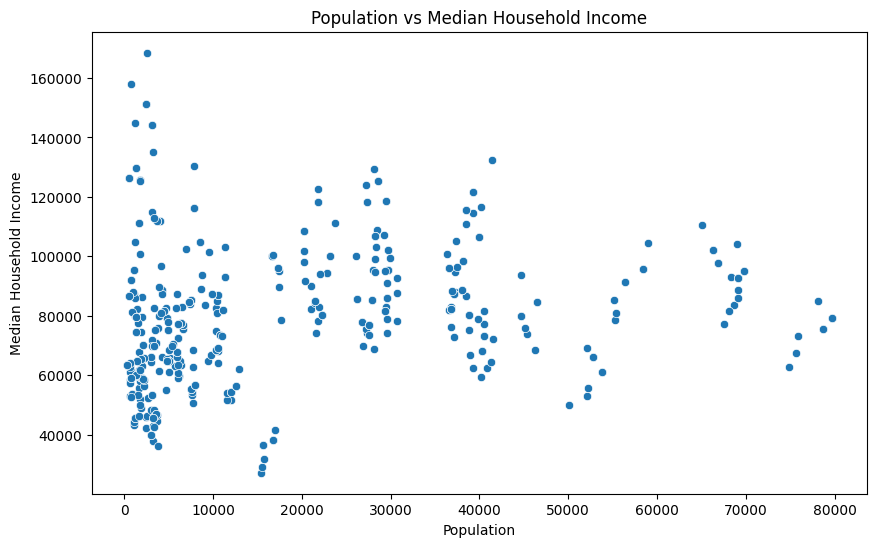

In [253]:
#plot a scatterplot of population size vs median household income
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total population', y='Median income (dollars)', data=data)
plt.title('Population vs Median Household Income')
plt.xlabel('Population')
plt.ylabel('Median Household Income')
plt.show()

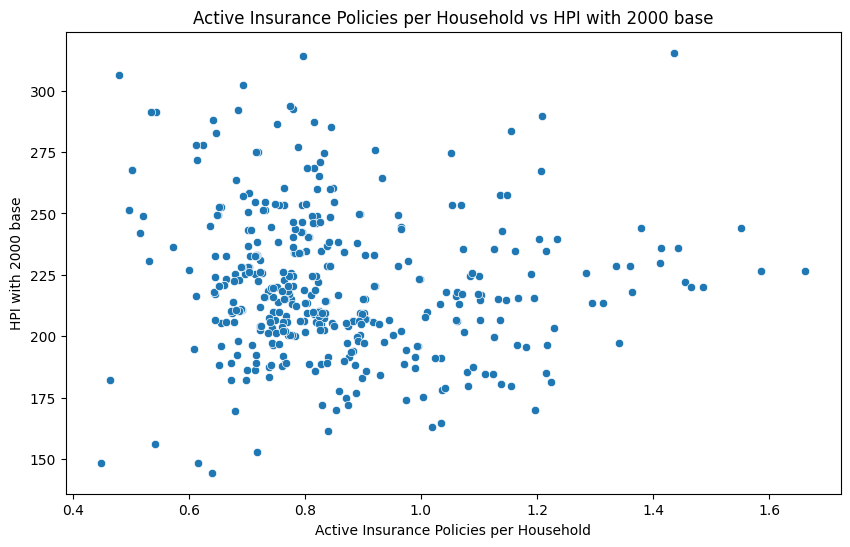

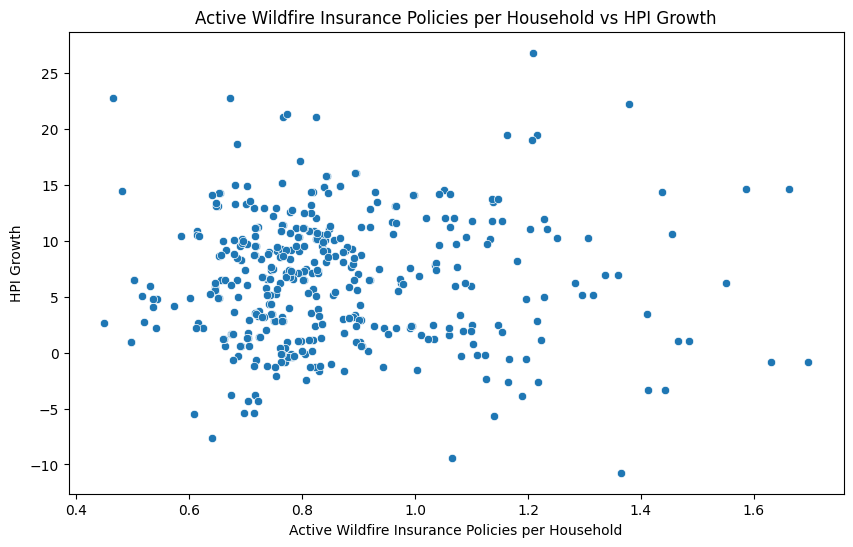

In [254]:
# Create a new column for the ratio of active insurance policies to the number of households
data['Insurance Coverage Rate'] = data['Active'] / data['Total (Households)']

# Plot a scatterplot of the ratio vs 

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Insurance Coverage Rate', y='HPI with 2000 base', data=data)
plt.title('Active Insurance Policies per Household vs HPI with 2000 base')
plt.xlabel('Active Insurance Policies per Household')
plt.ylabel('HPI with 2000 base')
plt.show()

#Plot a scatterplot of the ratio vs HPI growth
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Insurance Coverage Rate', y='Annual Change (%)', data=data)
plt.title('Active Wildfire Insurance Policies per Household vs HPI Growth')
plt.xlabel('Active Wildfire Insurance Policies per Household')
plt.ylabel('HPI Growth')
plt.show()

In [255]:
# number of data points for each year
print(data['Year'].value_counts())

2020.0    104
2021.0    104
2017.0     53
2018.0     53
2019.0     52
2022.0     52
Name: Year, dtype: int64


In [256]:
import statsmodels.api as sm

In [257]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data[[ 'Total (Households)', 'Insurance Coverage Rate' ]]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                  Variable       VIF
0       Total (Households)  1.689966
1  Insurance Coverage Rate  1.689966


In [258]:
# Select all variables for VIF testing
variables = ['Total (Households)', 'Insurance Coverage Rate'] + \
            ['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', 
             '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', 
             '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years', 
             '85 years and over'] + \
            ['Less than $10,000', '$10,000 to $14,999', '$15,000 to $24,999', 
             '$25,000 to $34,999', '$35,000 to $49,999', '$50,000 to $74,999', 
             '$75,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999', 
             '$200,000 or more']

# Compute VIF for all variables
X = data[variables].dropna()  # Ensure no missing data
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the results
print(vif_data)

                   Variable           VIF
0        Total (Households)      3.259117
1   Insurance Coverage Rate     45.044789
2             Under 5 years   1569.633629
3              5 to 9 years   1890.715429
4            10 to 14 years   1944.582279
5            15 to 19 years   2222.984660
6            20 to 24 years   2734.089955
7            25 to 34 years   8417.124961
8            35 to 44 years   7848.573084
9            45 to 54 years   9607.157002
10           55 to 59 years   3609.025725
11           60 to 64 years   3985.426578
12           65 to 74 years  12214.469232
13           75 to 84 years   2479.501711
14        85 years and over    464.457076
15        Less than $10,000   1396.891235
16       $10,000 to $14,999   1322.249482
17       $15,000 to $24,999   3309.379013
18       $25,000 to $34,999   3251.580488
19       $35,000 to $49,999   7189.554457
20       $50,000 to $74,999  15607.059208
21       $75,000 to $99,999  11056.346674
22     $100,000 to $149,999  17260

In [259]:
#Group brackets of income and age
data['Age 0-19 (%)'] = data[['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years']].sum(axis=1)
data['Age 20-64 (%)'] = data[['20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years']].sum(axis=1)
data['Age 65+ (%)'] = data[['65 to 74 years', '75 to 84 years', '85 years and over']].sum(axis=1)

data['Income < $50,000 (%)'] = data[['Less than $10,000', '$10,000 to $14,999', '$15,000 to $24,999', '$25,000 to $34,999', '$35,000 to $49,999']].sum(axis=1)
data['Income $50,000 - $99,999 (%)'] = data[['$50,000 to $74,999', '$75,000 to $99,999']].sum(axis=1)
data['Income $100,000+ (%)'] = data[['$100,000 to $149,999', '$150,000 to $199,999', '$200,000 or more']].sum(axis=1)

In [260]:
# Select all variables for VIF testing
variables = ['Total (Households)', 'Insurance Coverage Rate'] + \
            ['Age 0-19 (%)', 'Age 65+ (%)'] + \
            ['Income < $50,000 (%)']

# Compute VIF for all variables
X = data[variables].dropna()  # Ensure no missing data
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the results
print(vif_data)

                  Variable        VIF
0       Total (Households)   2.249009
1  Insurance Coverage Rate  15.481651
2             Age 0-19 (%)  10.164423
3              Age 65+ (%)   9.453902
4     Income < $50,000 (%)  10.891973


In [261]:
# adding interaction terms
data['Households_x_Insurance'] = data['Total (Households)'] * data['Insurance Coverage Rate']
data['Age0_19_x_IncomeLow'] = data['Age 0-19 (%)'] * data['Income < $50,000 (%)']
data['Age65+_x_IncomeLow'] = data['Age 65+ (%)'] * data['Income < $50,000 (%)']

#VIF
variables = ['Total (Households)', 'Insurance Coverage Rate', 'Households_x_Insurance', 'Age 0-19 (%)', 'Age 65+ (%)', 'Income < $50,000 (%)', 'Age0_19_x_IncomeLow', 'Age65+_x_IncomeLow']

# Compute VIF for all variables
X = data[variables].dropna()  # Ensure no missing data
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the results
print(vif_data)

                  Variable         VIF
0       Total (Households)   86.162253
1  Insurance Coverage Rate   30.180408
2   Households_x_Insurance   86.152910
3             Age 0-19 (%)   48.998151
4              Age 65+ (%)   49.789373
5     Income < $50,000 (%)  152.184005
6      Age0_19_x_IncomeLow   80.681896
7       Age65+_x_IncomeLow   78.510531


In [262]:
# maybe need to center/standardize data?
data['HPI with 2000 base'] = data['HPI with 2000 base'] - data['HPI with 2000 base'].mean()
data['Centered_Households'] = data['Total (Households)'] - data['Total (Households)'].mean()
data['Centered_Insurance'] = data['Insurance Coverage Rate'] - data['Insurance Coverage Rate'].mean()
data['Centered_Age0_19'] = data['Age 0-19 (%)'] - data['Age 0-19 (%)'].mean()
data['Centered_Age65+'] = data['Age 65+ (%)'] - data['Age 65+ (%)'].mean()
data['Centered_IncomeLow'] = data['Income < $50,000 (%)'] - data['Income < $50,000 (%)'].mean()

data['Households_x_Insurance'] = data['Centered_Households'] * data['Centered_Insurance']
data['Age0_19_x_IncomeLow'] = data['Centered_Age0_19'] * data['Centered_IncomeLow']
data['Age65+_x_IncomeLow'] = data['Centered_Age65+'] * data['Centered_IncomeLow']

#VIF
variables = ['Centered_Households', 'Centered_Insurance', 'Households_x_Insurance', 'Centered_Age0_19', 'Centered_Age65+', 'Centered_IncomeLow', 'Age0_19_x_IncomeLow', 'Age65+_x_IncomeLow']

# Compute VIF for all variables
X = data[variables].dropna()  # Ensure no missing data
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the results
print(vif_data)

                 Variable       VIF
0     Centered_Households  1.680992
1      Centered_Insurance  2.315909
2  Households_x_Insurance  2.111002
3        Centered_Age0_19  3.085196
4         Centered_Age65+  3.008296
5      Centered_IncomeLow  1.204065
6     Age0_19_x_IncomeLow  2.390142
7      Age65+_x_IncomeLow  2.402738


In [263]:
y_var_str = 'HPI with 2000 base'
# y_var_str = 'Annual Change (%)'

In [264]:
# Define dependent variable
y = data[y_var_str]

# Define independent variables
# X = data[['Insurance Coverage Rate', 'Total population', 'Total (Households)',
#           'Median income (dollars)', 'Mean income (dollars)']]
X = data[['Insurance Coverage Rate', 'Total (Households)']]

# Add demographic controls
age_groups = ['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', 
              '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', 
              '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years', 
              '85 years and over']
X = X.join(data[age_groups])

# Add household income distribution as controls
income_brackets = ['Less than $10,000', '$10,000 to $14,999', '$15,000 to $24,999',
                   '$25,000 to $34,999', '$35,000 to $49,999', '$50,000 to $74,999',
                   '$75,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999',
                   '$200,000 or more']
X = X.join(data[income_brackets])

# Add year fixed effects
X = pd.get_dummies(data['Year'], prefix='Year').join(X)

# Fit regression model
X = sm.add_constant(X)  # Add constant term for intercept
model = sm.OLS(y, X, missing='drop').fit()

#send X to csv for further analysis
X.to_csv('X.csv', index=False)

# View results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     HPI with 2000 base   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     26.47
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           1.52e-73
Time:                        14:17:30   Log-Likelihood:                -1663.9
No. Observations:                 395   AIC:                             3390.
Df Residuals:                     364   BIC:                             3513.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1

In [265]:
# Regression with interaction terms and centered variables
# Define dependent variable
y = data[y_var_str]

# Define independent variables
X = data[['Centered_Households', 'Centered_Insurance', 'Households_x_Insurance', 'Centered_Age0_19', 'Centered_Age65+', 'Centered_IncomeLow', 'Age0_19_x_IncomeLow', 'Age65+_x_IncomeLow']]
X = sm.add_constant(X)  # Add constant

# add year fixed effects
X = pd.get_dummies(data['Year'], prefix='Year').join(X)

# Fit regression model
model = sm.OLS(y, X, missing='drop').fit()

# View results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     HPI with 2000 base   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     37.63
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           2.63e-60
Time:                        14:17:30   Log-Likelihood:                -1729.4
No. Observations:                 395   AIC:                             3487.
Df Residuals:                     381   BIC:                             3542.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Year_2017.0                1

In [266]:
import statsmodels.formula.api as smf

In [268]:
#let's split 2020-2022 as the post disaster period and 2017-2019 as the pre disaster period using a DiD approach
data['Post_Disaster'] = (data['Year'] >= 2020).astype(int)

data['Post_x_Households'] = data['Post_Disaster'] * data['Centered_Households']
data['Post_x_Insurance'] = data['Post_Disaster'] * data['Centered_Insurance']
data['Post_x_Age0_19'] = data['Post_Disaster'] * data['Centered_Age0_19']
data['Post_x_Age65+'] = data['Post_Disaster'] * data['Centered_Age65+']
data['Post_x_IncomeLow'] = data['Post_Disaster'] * data['Centered_IncomeLow']

# Regression with interaction terms and centered variables
# Define dependent variable
y = data[y_var_str]

# Define independent variables
X = data[['Post_Disaster', 'Centered_Households', 'Centered_Insurance', 'Households_x_Insurance', 'Post_x_Households', 'Post_x_Insurance', 'Centered_Age0_19', 'Centered_Age65+', 'Centered_IncomeLow', 'Age0_19_x_IncomeLow', 'Age65+_x_IncomeLow', 'Post_x_Age0_19', 'Post_x_Age65+', 'Post_x_IncomeLow']]
X = sm.add_constant(X)  # Add constant

# # add year fixed effects
# X = pd.get_dummies(data['Year'], prefix='Year').join(X)

# Fit regression model
model = sm.OLS(y, X, missing='drop').fit()

# View results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     HPI with 2000 base   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     13.43
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           6.82e-26
Time:                        14:18:29   Log-Likelihood:                -1813.1
No. Observations:                 395   AIC:                             3656.
Df Residuals:                     380   BIC:                             3716.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    201

In [224]:
# Filter data for pre-disaster and post-disaster periods
pre_disaster_data = data[data['Post_Disaster'] == 0]
post_disaster_data = data[data['Post_Disaster'] == 1]

#omit 2020 data
# post_disaster_data = post_disaster_data[post_disaster_data['Year'] != 2020]

# Define dependent variable
y_pre = pre_disaster_data[y_var_str]
y_post = post_disaster_data[y_var_str]

# Define independent variables
X_pre = pre_disaster_data[['Centered_Households', 'Centered_Insurance', 'Households_x_Insurance', 'Centered_Age0_19', 'Centered_Age65+', 'Centered_IncomeLow', 'Age0_19_x_IncomeLow', 'Age65+_x_IncomeLow']]
X_post = post_disaster_data[['Centered_Households', 'Centered_Insurance', 'Households_x_Insurance', 'Centered_Age0_19', 'Centered_Age65+', 'Centered_IncomeLow', 'Age0_19_x_IncomeLow', 'Age65+_x_IncomeLow']]

# Add constant term for intercept
X_pre = sm.add_constant(X_pre)
X_post = sm.add_constant(X_post)

# Fit regression models
model_pre = sm.OLS(y_pre, X_pre, missing='drop').fit()
model_post = sm.OLS(y_post, X_post, missing='drop').fit()

# # View results
# print("Pre-Disaster Period Regression Results:")
# print(model_pre.summary())

print("\nPost-Disaster Period Regression Results:")
print(model_post.summary())


Post-Disaster Period Regression Results:
                            OLS Regression Results                            
Dep. Variable:      Annual Change (%)   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.327
Date:                Fri, 13 Dec 2024   Prob (F-statistic):              0.231
Time:                        14:03:08   Log-Likelihood:                -825.50
No. Observations:                 255   AIC:                             1669.
Df Residuals:                     246   BIC:                             1701.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------